# Imports, Definitions, and Instantiating the overlay

In [1]:
import logging
import numpy as np
import time
import pynq
from pynq import PL, Overlay, DefaultIP, allocate
from fpbinary import FpBinary, OverflowEnum, RoundingEnum
import itertools
import matplotlib.pyplot as plt
import scipy.signal

FP16_15 = lambda x: FpBinary(int_bits=1, frac_bits=15, signed=True, value=x)
FP26_26 = lambda x: FpBinary(int_bits=0, frac_bits=26, signed=True, value=x)
FP16_26 = lambda x: FpBinary(int_bits=-10, frac_bits=26, signed=True, value=x)
FP32_31 = lambda x: FpBinary(int_bits=1, frac_bits=31, signed=True, value=x)
FP18_17 = lambda x: FpBinary(int_bits=1, frac_bits=17, signed=True, value=x)
FP16_25 = lambda x: FpBinary(int_bits=-9, frac_bits=25, signed=True, value=x)
FP18_25 = lambda x: FpBinary(int_bits=-7, frac_bits=25, signed=True, value=x)
FP16_17 = lambda x: FpBinary(int_bits=-1, frac_bits=17, signed=True, value=x)

logging.basicConfig()

n_res = 2048

Create a driver, load the overlay, and extract the dma and ip cores

In [2]:
class ResonatorDDSIP(DefaultIP):
    toneinc_offset = 0x1000
    phase0_offset = 0x2000

    def __init__(self, description):
        """

        Note the axilite memory space is
        0x1000 ~
        0x1fff : Memory 'toneinc_V' (256 * 128b)
                 Word 4n   : bit [31:0] - toneinc_V[n][31: 0]
                 Word 4n+1 : bit [31:0] - toneinc_V[n][63:32]
                 Word 4n+2 : bit [31:0] - toneinc_V[n][95:64]
                 Word 4n+3 : bit [31:0] - toneinc_V[n][127:96]
        0x2000 ~
        0x2fff : Memory 'phase0_V' (256 * 128b)
                 Word 4n   : bit [31:0] - phase0_V[n][31: 0]
                 Word 4n+1 : bit [31:0] - phase0_V[n][63:32]
                 Word 4n+2 : bit [31:0] - phase0_V[n][95:64]
                 Word 4n+3 : bit [31:0] - phase0_V[n][127:96]
        """
        super().__init__(description=description)

    bindto = ['MazinLab:mkidgen3:resonator_dds:0.6']

    @staticmethod
    def _checkgroup(group_ndx):
        if group_ndx < 0 or group_ndx > 255:
            raise ValueError('group_ndx must be in [0,255]')

    def read_group(self, offset, group_ndx):
        """Read the numbers in group from the core and convert them from binary data to python numbers"""
        self._checkgroup(group_ndx)
        signed = offset == self.toneinc_offset
        vals = [self.read(offset + 16 * group_ndx + 4 * i) for i in range(4)]  # 2 16bit values each
        ret = [float(FpBinary(1, 15, signed=signed, bit_field=(v >> (16 * i)) & 0xffff))
               for v in vals for i in (0, 1)]
        # print(f"Read {bin(vals[0]&0xffff)} from the first address.")
        return ret

    def write_group(self, offset, group_ndx, group):
        """Convert the numbers in the group from python data to binary data and load it into the core"""
        self._checkgroup(group_ndx)
        if len(group) != 8:
            raise ValueError('len(group)!=8')
        signed = offset == self.toneinc_offset
        bits = 0
        fixedgroup = [FpBinary(int_bits=1, frac_bits=15, signed=signed, value=g) for g in group]
        for i, (g0, g1) in enumerate(zip(*[iter(fixedgroup)] * 2)):  #take them by twos
            bits |= ((g1.__index__() << 16) | g0.__index__()) << (32 * i)
        data = bits.to_bytes(32, 'little', signed=False)
        self.write(offset + 16 * group_ndx, data)

    def toneinc(self, res):
        """ Retrieve the tone increment for a particular resonator """
        return self.read_group(self.toneinc_offset, res // 8)[res % 8]

    def phase0(self, res):
        """ Retrieve the phase offset for a particular resonator """
        return self.read_group(self.phase0_offset, res // 8)[res % 8]

    @property
    def toneincs(self):
        return [v for g in range(256) for v in self.read_group(self.toneinc_offset, g)]

    @toneincs.setter
    def toneincs(self, toneincs):
        if len(toneincs) != 2048:
            raise ValueError('len(toneincs)!=2048')
        if min(toneincs) < -1 or max(toneincs) >= 1:
            raise ValueError('Tone increments must be in [-1,1)')
        for i in range(256):
            self.write_group(self.toneinc_offset, i, toneincs[i * 8:i * 8 + 8])

    @property
    def phase0s(self):
        return [v for g in range(256) for v in self.read_group(self.phase0_offset, g)]

    @phase0s.setter
    def phase0s(self, phase0s):
        if len(phase0s) != 2048:
            raise ValueError('len(phase0s)!=2048')
        if min(phase0s) < 0 or max(phase0s) > 1:
            raise ValueError('Phase offsets must be in [0,1]')
        for i in range(256):
            self.write_group(self.phase0_offset, i, phase0s[i * 8:i * 8 + 8])


In [3]:
n_packets_rcvd, n_packets_sent, pptx, input_buffer = 0, 0, None, None
next_sample_send=0

def prep_buffers(ntx=16, n_res=2048):
    global pptx, input_buffer, output_buffer
    pptx = ntx

    try:
        # Close buffers if they are open
        input_buffer.close()
        output_buffer.close()
    except (NameError,AttributeError):
        pass

    # Create the buffers
    input_buffer = allocate(shape=(n_res * 2 * pptx,), dtype=np.uint16)  # 2048 I & Q
    output_buffer = allocate(shape=(n_res * 2,), dtype=np.uint16)


def packet_to_buffer(packet, fpgen=FP16_15):
    """
    Converts a packet of complex data into a n_res*2 uint16 array

    Packet should be an array of dtype=np.complex64 or 128.

    FpBinary will be used to convert the data from float to fixed point (signed 16_15 by default).
    """

    if fpgen is None:
        ibits = [int(x) for x in packet.real]
        qbits = [int(x) for x in packet.imag]
    else:
        ibits = [fpgen(x).__index__() for x in packet.real]
        qbits = [fpgen(x).__index__() for x in packet.imag]
    data = np.zeros(2 * packet.size, dtype=np.uint16)
    data[::2] = ibits
    data[1::2] = qbits
    return data


def packet_from_buffer(buffer, fpformat=(-9,25)):
#     ibits = np.zeros(buffer.size // 2, dtype=np.uint16)
#     qbits = np.zeros(buffer.size // 2, dtype=np.uint16)
    packet = np.zeros(buffer.size // 2, dtype=np.complex128)
    
    ibits = buffer[0::2]
    qbits = buffer[1::2]

    if fpformat is None:
        fp = lambda x: int(x)
    else:
        fp = lambda x: FpBinary(int_bits=fpformat[0], frac_bits=fpformat[1], signed=True, bit_field=int(x))
    packet.real = [float(fp(x)) for x in ibits]
    packet.imag = [float(fp(x)) for x in qbits]
    return packet


def txrx(dma, comb, nper, packets_out, n_total_packets=None, packet_latency=1, in_per_out=2,
         txfp=FP16_15, rxfp=(-9,25), wait=True, show=False):
    global n_packets_rcvd, n_packets_sent, pptx, input_buffer, next_sample_send
    
    if n_total_packets is None:
        n_total_packets=comb.size//256//8
    
    
    prep_buffers(nper)
    n_loop=(n_total_packets - n_packets_sent) // pptx
    
    print(f'Will send {(n_total_packets - n_packets_sent)} packets in {n_loop} iterations')

    for i in range(n_loop):
        
        #Send data
        n_to_send = pptx * n_res
        data = comb.ravel()[next_sample_send:next_sample_send + n_to_send]
        input_buffer[:] = packet_to_buffer(data, fpgen=txfp)
        
        dma.sendchannel.transfer(input_buffer)

        if wait:
            if show:
                print(f"Sent {pptx}, waiting.")
            dma.sendchannel.wait()
        next_sample_send += n_to_send
        n_packets_sent = next_sample_send // n_res
        
        #How many are are available to be recieved
        pending = n_packets_sent//in_per_out - n_packets_rcvd - packet_latency
        
        if show:
            print(f"Sent: {n_packets_sent}  Pending: {pending}")
            
        for i in range(pending):
            if show:
                print(f"Receiving packet {n_packets_rcvd}")
            dma.recvchannel.transfer(output_buffer)
            if wait:
                dma.recvchannel.wait()
            packets_out[n_packets_rcvd] = packet_from_buffer(output_buffer, fpformat=rxfp)
            n_packets_rcvd += 1

        if show:
            print(f"Received: {n_packets_rcvd}.")

def dds(p):
    return np.cos(np.pi*p)+np.sin(np.pi*p)*1j

In [4]:
ol = Overlay('/home/xilinx/overlayfiles/test_ddc/test_ddc.bit',ignore_version=True)
ol.download()
print(f"PL Bitfile: {PL.bitfile_name}\nPL Timestamp: {PL.timestamp}\n"
      f"Overlay timestamp: {ol.timestamp}  Loaded: {ol.is_loaded()}")

PL Bitfile: /home/xilinx/overlayfiles/test_ddc/test_ddc.bit
PL Timestamp: 2020/5/12 1:36:31 +261552
Overlay timestamp: 2020/5/12 1:36:31 +261552  Loaded: True


In [5]:
dma=ol.axi_dma_0
ddc_core=ol.resonator_dds_0

## Prepare data to send

Send a repeating pattern of 2048 numbers spread evenly from min to max representable by a 16 bit wide -9 integer fixed point number. Leave the imaginary portion 0.

In [6]:
n_packets=200

inreal=np.linspace(2**-24, 2**-11,2048)  #8 times the fixed point quantization
data=(inreal+0j)[np.newaxis,:]*np.ones(n_packets)[:,np.newaxis]
packets_out=np.zeros((data.shape[0], n_res), dtype=np.complex64)

## Configure the core

In [7]:
phase0s=np.zeros(2048)
toneincs=np.zeros(2048)

In [8]:
ddc_core.toneincs=toneincs
phase0s[:]=.25
ddc_core.phase0s=phase0s  

In [9]:
print('Reading toneinc group 0',ddc_core.read_group(ddc_core.toneinc_offset, 0))
print('Reading toneinc group 1',ddc_core.read_group(ddc_core.toneinc_offset, 1))
print('Reading toneinc group 255',ddc_core.read_group(ddc_core.toneinc_offset, 255))
print('Reading phase offset group 0',ddc_core.read_group(ddc_core.phase0_offset, 0))
print('Reading phase offset group 255',ddc_core.read_group(ddc_core.phase0_offset, 255))

Reading toneinc group 0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reading toneinc group 1 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reading toneinc group 255 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Reading phase offset group 0 [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
Reading phase offset group 255 [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


## Send the data & compute expected outputs
Send in groups of 6 packets

In [10]:
data=(np.arange(2048)+0j)[np.newaxis,:]*np.ones(n_packets)[:,np.newaxis]

In [11]:
npack=6
phase0_progression=np.array([0,.5,0,1,0])
expected=np.zeros_like(data)

This things step by step to allow arming the System ILA

In [12]:
i=0
sl=slice(n_packets_sent, n_packets_sent+npack)
phase=phase0_progression[i]
phase0s[:]=phase
ddc_core.phase0s=phase0s  
expected[sl,:]=(data[sl,:]*dds(phase))
txrx(dma, data, 6, packets_out, n_total_packets=npack*(i+1), packet_latency=1, wait=True, show=True, 
     txfp=None, rxfp=None, in_per_out=1)

Will send 6 packets in 1 iterations
Sent 6, waiting.
Sent: 6  Pending: 5
Receiving packet 0
Receiving packet 1
Receiving packet 2
Receiving packet 3
Receiving packet 4
Received: 5.


In [13]:
i=1
sl=slice(n_packets_sent, n_packets_sent+npack)
phase=phase0_progression[i]
phase0s[:]=phase
ddc_core.phase0s=phase0s  
expected[sl,:]=(data[sl,:]*dds(phase))
txrx(dma, data, 6, packets_out, n_total_packets=npack*(i+1), packet_latency=1, wait=True, show=True, 
     txfp=None, rxfp=None, in_per_out=1)

Will send 6 packets in 1 iterations
Sent 6, waiting.
Sent: 12  Pending: 6
Receiving packet 5
Receiving packet 6
Receiving packet 7
Receiving packet 8
Receiving packet 9
Receiving packet 10
Received: 11.


In [41]:
i=2
sl=slice(n_packets_sent, n_packets_sent+npack)
phase=phase0_progression[i]
phase0s[:]=phase
ddc_core.phase0s=phase0s  
expected[sl,:]=(data[sl,:]*dds(phase))
txrx(dma, data, 6, packets_out, n_total_packets=npack*(i+1), packet_latency=1, wait=True, show=True, 
     txfp=None, rxfp=None, in_per_out=1)

Will send 6 packets in 1 iterations
Sent 6, waiting.
Sent: 18  Pending: 6
Receiving packet 11
Receiving packet 12
Receiving packet 13
Receiving packet 14
Receiving packet 15
Receiving packet 16
Received: 17.


In [42]:
i=3
sl=slice(n_packets_sent, n_packets_sent+npack)
phase=phase0_progression[i]
phase0s[:]=phase
ddc_core.phase0s=phase0s  
expected[sl,:]=(data[sl,:]*dds(phase))
txrx(dma, data, 6, packets_out, n_total_packets=npack*(i+1), packet_latency=1, wait=True, show=True, 
     txfp=None, rxfp=None, in_per_out=1)

Will send 6 packets in 1 iterations
Sent 6, waiting.
Sent: 24  Pending: 6
Receiving packet 17
Receiving packet 18
Receiving packet 19
Receiving packet 20
Receiving packet 21
Receiving packet 22
Received: 23.


## Look at results

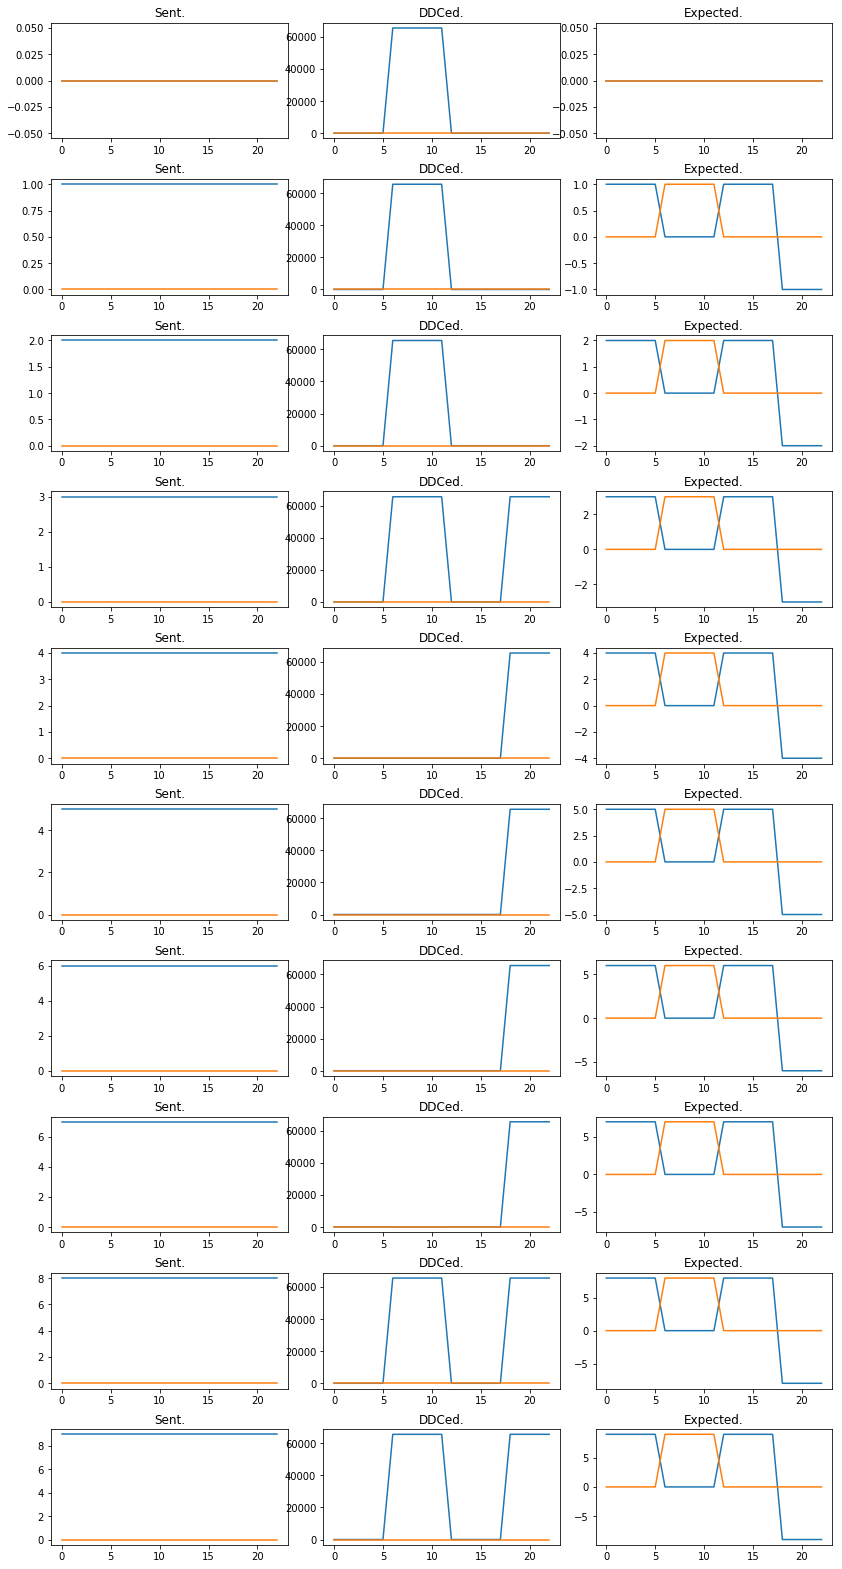

In [43]:
n=n_packets_rcvd
nplot=10
_,axes = plt.subplots(nplot,3,figsize=(14,2.8*nplot))
for i,(raw, ddc, exp) in enumerate(zip(data[:n,:nplot].T,packets_out[:n,:nplot].T,expected[:n,:nplot].T)):
    plt.sca(axes[i,0])
    plt.plot(raw.real)
    plt.plot(raw.imag)
    plt.title(f"Sent.")
    plt.sca(axes[i,1])
    plt.plot(ddc.real)
    plt.plot(ddc.imag)
    plt.title(f"DDCed.")
    plt.sca(axes[i,2])
    plt.plot(exp.real)
    plt.plot(exp.imag)
    plt.title(f"Expected.")
plt.subplots_adjust(wspace=.15, hspace=.35)